# Notebook 2: Chain Rule [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mattsankner/micrograd/blob/main/mg2_chain_rule.ipynb)  [![View in nbviewer](https://img.shields.io/badge/view-nbviewer-orange)](https://nbviewer.jupyter.org/github/mattsankner/micrograd/blob/main/mg2_chain_rule.ipynb)

## Welcome to the second mini-lecture!

Now that we have some sense of what the derivative tells us about the function, let's start by building out a Value class for our previous values $a, b, c$. This way, we can ascribe more properties to them than just their value. 

As we move to neural networks, we need good data structures that can hold massive mathematical expressions. Here's the class that makes Value objects:

In [61]:
#class Value takes a single scalar value that it wraps and keeps track of.
class Value:

#each Value object will have data, children Value nodes , an operator (+, -, *, etc.), a label, and a gradient. These are explained below.
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
      
#returns a value wrapper with the data. Prints out a nice expression, instead of something crytpic
  def __repr__(self):
    return f"Value(data={self.data})"
      
a = Value(2.0)
a

Value(data=2.0)

Now, we want to be able to do $a+b$, but currently python doesn't know how to add two of our Value objects.

In python, we need to use special double underscore operators to define the operators for the objects, using special, specific names like ```__add__```, etc.
Let's define the add and multiply function.

In [63]:
class Value:
    
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
      
  def __repr__(self):
    return f"Value(data={self.data})"

#to match built in python function .__add__()
  def __add__(self, other):
    out = Value(self.data + other.data)
    return out
      
#to match built in python function .__mul__()
  def __mul__(self, other):
    out = Value(self.data * other.data)
    return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

a * b + c   #equivalent in python to a.__mul__(b).__add__(c). If it were addition, it would be a.__add__(b).__add__(c). Can call this manually

Value(data=4.0)

We want to create children Value nodes that show how we got to the value we're at. This will be stored in the 
```_children=()``` tuple, which will be stored in a set of ```_children, self.prev.``` Notice self._prev below.


When we create a value through addition or multiplicatoin, we want to pass in these children of the value, which is ```(self, other)``` into the operator.

Now, we know the children of the ```Value``` object , but not the operation. Notice we add the operation sign at the end of the ```Value``` object creation in the ```out```.


In [86]:
class Value:
    
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
      
  def __repr__(self):
    return f"Value(data={self.data})"

#to match built in python function .__add__()
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out
      
#to match built in python function .__mul__()
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')  #added labels
e = a*b; e.label = 'e'      #added e for a * b
d = e + c; d.label = 'd'
print(d._prev)
print(d._op)

{Value(data=-6.0), Value(data=10.0)}
+


As we build out the expression, we want to build out something that can help us visualize the expressions. We will use the Graphviz api for this. Before we understand what the code does, visualize what it does below by running the defintion block and then ```draw_dot()``` on our previous value ```d```. Then, read the function comments to help you understand the code. Ultimately, it's not uber important to understand the finer details of ```trace()``` and ```draw_dot()```.

We can call ```draw_dot()``` on a root node (```Value``` obj), and ```trace()``` will visualize it.

In [76]:
!pip install graphviz
!export PATH="/usr/local/opt/graphviz/bin:$PATH"


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [84]:
from graphviz import Digraph #graphviz is an opensource vizualization software. We are building out this graph in graphviz API. 

def trace(root): #helper function that enumerates the ndoes and edges in the graph
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root): #creating op nodes (not Value objects)
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root) #call trace
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad % .4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it. Not a value object
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

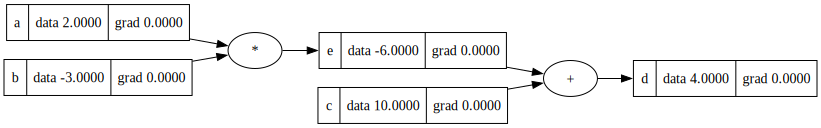

In [91]:
draw_dot(d) 

Above, we can visualize ```a * b + c```.

Now, let's add variables ```f```, and a return variable ```L```, and re-run ```draw_dot(L)```.

In [93]:
class Value:
    
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
      
  def __repr__(self):
    return f"Value(data={self.data})"

#to match built in python function .__add__()
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out
      
#to match built in python function .__mul__()
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')  #added labels
e = a*b; e.label = 'e'      #added e for a * b
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; label = 'L'
L

Value(data=-8.0)

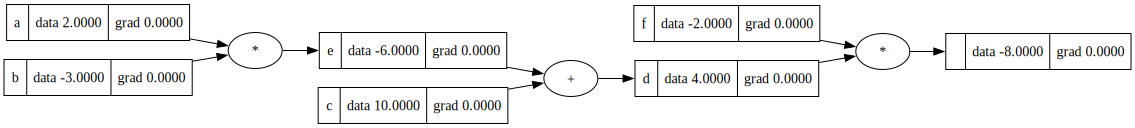

In [92]:
draw_dot(L)

### Let's recap. 

We've built out scalar valued mathematical expressions using $+$ and $*$. We can do a forward pass with multiple inputs going into the expression that produces the single output ```L```. ```Draw_dot(L)``` visualizes the forward pass. 

Next, we run backpropagation, where we reverse and calculate the gradient along all of the intermediate values. For every single value, we compute the derivative of that node with respect to ```L```. The derivative of ```L``` with respect to ```L``` is ```1```. Now, we derive ```L``` with respect to ```f, d, c, e, b,``` and then ```a```|. 

In a neural network setting, you would be very interested in the derivative of the loss function ```L``` with respect to the weights of the neural network. These variables will eventually represent the weights of the neural network. We need to know how those weights are impacting the loss function, so we would be interested in the derivative of the output with respect to some of its leaf nodes. The leaf nodes will be weigths of the neural net. And the other leaf nodes will be the data itself, but we won't take the derivative of these, because the data is fixed, but not the weights.



In the next exercise, we will focus on the ```self.grad``` in the Value class above, which will maintain the derivative of ```L``` with respect to a ```Value```. It will be initialized to $0$, which means it will start with no impact on the output (changing the variable does not change the loss function).

### We will start to fill in the gradients.

We'll implement a dummy function with local variables (not affecting the local scope). Read the commments and follow along.

In [102]:
def dummyFunction():
    h = 0.0001 #small a mount to add

    #same as last time
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data               #use.data because they're floats

    a = Value(2.0 + h, label='a')   #we choose to bump a by h, so we can later get the derivative of L with respect to a
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data         # base case would be adding h to L -> L2 = L.data + h = 1

    print((L2 - L1)/h)  #rise over run -> change in L over tiny change to a
        
                        #should print derivative of L with respect to  a because a is what we bumped by h. Answer is 6. Check output.

                       
                        
                        #Adding a small amount (h) to a -> measures L with respect to a

#when testing derivatives, plug in ( + h) to any of the value objects in L2. For example, if finding the derivative of L with respect to f,
#add h to -2.0 in f's value object

dummyFunction()

6.000000000021544


Now, let's set a gradient:

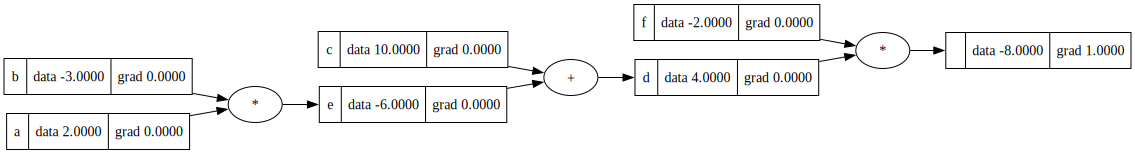

In [104]:
L.grad = 1.0 #manual backpropagation
draw_dot(L) #look at L.grad

Now, we want to get the value of ```d.grad``` and ```f.grad```. To do this, we derive $dL/dd$ and $dL/df$:

$L = d * f$

$dL/dd = ?$  (ends up being ```f```)

Proof:

$f(x + h) - f(x)) / h =$

$((d + h) * f - d * f) / h =$      

$(d+f + h * f - d * f) / h =$    

$(h*f)/h =$  

$f$


**The same is true for $dL/df$; it ends up deriving to $d$. Let's set the grads and redraw.**


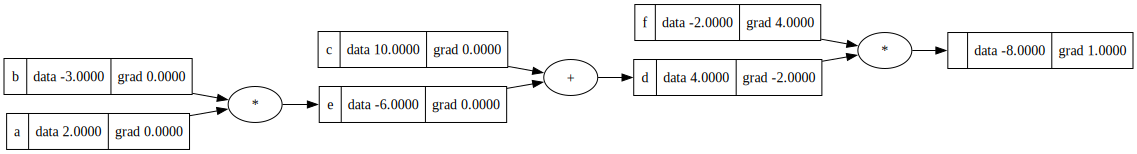

In [108]:
f.grad = 4.0  #value of d.data
d.grad = -2.0 #value of f.data
draw_dot(L)
#to test that these work, go back to dummyFunction() and increment d.data or f.data by h, and view the output. It should be the given grad.

### Now, we are continuing the backpropagation by calculating the derivative of L with respect to C. Also will derive dL by de (dL/de). 

dL/dc : derivative of L with respect to C. 

How do we derive dL by dC?


We already know derivative of ```L``` with respect to ```d```. So we know how ```L``` is sensitive to ```d```. But how is ```L``` sensitive to ```C```?
So if we adjust ```C```, how does that impact ```L``` through ```d```? if know impact ```c``` on ```d``` and ```d``` on ```L```, should be able to put it together to figure out how ```c``` impacts ```L```.

```dd/dc```?

$d = c + e$ -> differentiating $c+e$ with respect to $c$ gives you $1 + 0$. 

Can derive/prove this:

$f(x+h) - f(x) / h$

$dd/dc = ((c + e + h) - ( c + e )) / h$

$(c + h + e -c -e) / h -> h/h = 1.0$

$dd/dc = 1.0$

Symetrically, $dd/de = 1.0$.

The local derivative of the sum is very simple. All is knows is the local ```+```. The + node only nodes the derivatives of ```d``` with respect to ```e```, and ```d``` with respect to ```c```. And it knows that it took ```c``` and ```e``` and added them and made ```d```. This little ```+``` node can be embedded in a massive graph. 

Now we know how to derive ```c``` and ```e``` from ```d```, and ```d``` from ```c```, but how do we put it all together? We ultimately want not just the local derivative, but $dL/dc$.

Answer: the chain rule in calculus: https://en.wikipedia.org/wiki/Chain_rule

## Chain rule explained:

- If a variable ```z``` depends on the variable ```y```, and ```y``` depends on the variable ```x```, (that is, ```y``` and ```z``` are dependent variables), then ```z``` depends on ```x``` as well, via the intermediate variable ```y```. In this case, the chain rule is expressed as $dz/dx = dz/dy * dy/dx$

- For our use case, $dL/dc = dL/dd * dd/dc$

- **This is how we chain these derivatives together, correctly. To differentiate through a function composition, we have to apply a multiplication of those derivatives.**

- Knowing the instantaneous rate of change of ```z``` relative to ```y``` and that of ```y``` relative to ```x``` allows one to calculate the instantaenous rate of change of ```z``` relative to ```x``` as the product of the two rates of change.

### Example: 

- If a ```car``` travels $2x$ as fast as a ```bicycle``` and the ```bicycle``` is $4x$ as fast as the ```walking man```, then the car travels $2 x 4 = 8x$ as fast as the man.
- If we use the chain rule: let ```z```, ```y```, and ```x``` be the variable positions of the ```car```, ```bicycle```, and the ```walking man```. The rate of change of the relative poisitons of the ```car``` and the ```bicycle``` is $dz / dy = 2$. Then, $dy / dx = 4$. So the rate of change of the relative positions of the ```car``` and the ```walking man``` is $dz/dx = dz/dy * dy/dx = 2 * 4 = 8$

### Now that we have an idea about the chain rule, let's find dL/dc.

$dd/de = 1.0$
$dd/dc = 1.0$ -> local derivatives are 1
$d = c + e$

KNOW: 
$dL / dd = -2$
$dd / dc = 1$

WANT:
Chain Rule: $dL / dc = (dL / dd) * (dd / dc)$

A $(+)$ node is routes the gradient because the $(+)$ node's gradients are just $1$
So in the chain rule, $1 x dL/dd = dL/dd$, so the derivative just gets routed to $c$ and $e$

Backpropogating signal that is flowing backwards through the graph, carrying the info of what the dL with respect to all the intermediate nodes, a $(+)$ node simply distributes a derivative to all its children


In [110]:
#Thus... 
c.grad = -2.0 #-2 * 1 -> dL/dc
e.grad = -2.0 #-2 * 1 -> dL/de

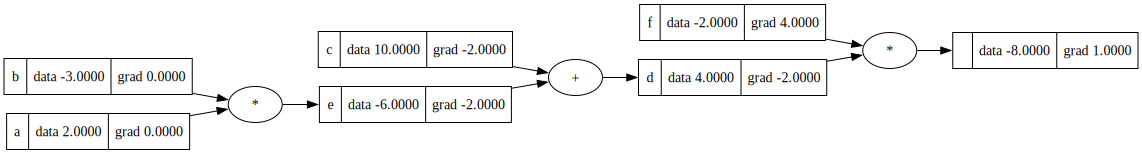

In [114]:
draw_dot(L) #now we have the derivative of L with respect to c and e (grad for c and e)
#This backpropogating signal is carrying information of the gradients from the end to the start through the intermediate nodes.
#The + node distributes the derivative to its children.

Now, let's increment c.data instead in our dummy function. Can you guess what we'll get as our answer for $(L2-L1)/h$?

In [128]:
def dummyFunction():
    h = 0.0001 #small a mount to add

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data               

    a = Value(2.0, label='a')   
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c.data += h                   #increment c by h
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data         

    print((L2 - L1)/h)  
    
dummyFunction()

-1.9999999999953388


As expected! It's -2, the same as c.grad.

Now we are going to keep applying the chain rule recursively through the graph. Now, we have dL/de is -2:

$dL / de = -2.0$

$dL / da = (dL / de) * (de / da)$  (Chain Rule)

$dL / db = (dL / de) * (de / db)$  (Chain Rule)

So, we need to find out $de/da$ and $de/db$.

$de/da = a * b; e = a * b$

To get $de/da$, we differentiate it as we did before with two variables joined by a multiplication operator. That will give us $de/da = b.data$: ```b = -3.0```

As a reminder, the formula to differentiate is:  $f(x) = f(x + h) -f(x) / h$

calculating the rate of change of $e$ with respect to $a$, and calculating the difference in the variable $e$ when $a$ is increased by small amount $h$ and then divide that difference by $h$.

$de/da = lim h-> 0: e(a + h) - e(a) / h$    -> then incrememt by $h$. For the proof for $de/da$:

$e(a + h) / h = e(a) / h$

$e(a + h) / h = (a + h) * b / h$

$e(a + h) = (a + h) * b$

$e(a + h) - e(a) = (a + h) * b - a * b$

$(a + h) * b - a * b = a * b + b * h - a * b$

$= h * b$

Divide by $h: (e(a+h)-e(a))/h = (h * b) / h$

$= b$
                        
$dL / da = (dL / de) * (de / da) = (dL / de) * b$

$dL / db = (dL / de) * (de / db) = (dL / de) * a$



### That's how we derive $de/da$ and $de/db$, and put it all together the chain rule to get $dL/da$ and $dL/db$. Let's set those gradients and redraw:

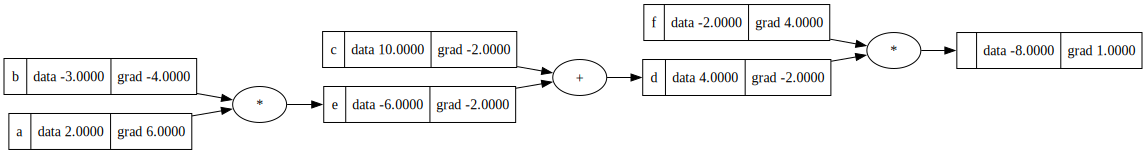

In [117]:
a.grad = -2.0 * -3.0  
b.grad = -2.0 * 2.0
draw_dot(L)

Now, let's make sure our claims of ```a.grad``` and ```b.grad``` are true. Below we increment $a$ by $h$ and expect to get ```a.grad```.

In [123]:
def dummyFunction():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    a.data += h                #increment a by h, expect to see a.grad
    b = Value(-3.0, label='b')
    #b.data += h               can do the same with b.data
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

dummyFunction()

6.000000000021544


### Manual Backpropogation Summary

- iterated through all nodes 1 by 1 and locally applied the chain rule
- We always know what the derivative of L is with respect to the local output
- The output was produced through some operation, and we have the pointers to its children nodes of the operation
- In this operation, we know what the local derivatives are, and we just multiply them onto the derivative
- We just go through and recursively multiply on the local derivatives
- That's backpropatation!
- **Backpropagation is just a recursive application of the chain rule backwards through the computational graph**

Let's see it in action! We'll nudge our inputs to make $L$ go up. If we want $L$ to go up, that means we have to go in the direction of the gradient.
$a, b, c,$ and $f$  should increase in the direction by a small step size. 
These nodes are the leaf nodes which we have control over. $L$ should go up postively if we nudge in the direction of the gradient.

In [126]:
#one step of optimization, gradients give us power because we know how to influence the final outcome.

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

#re-run forward pass
e = a * b
d = e + c
L = d * f

print(L.data)
#because we nudge the leaf nodes in the direction of the gradient, we expect L.data to go up. Right now, it's -8.
#this is one step of an optimization of our neural network. The gradients tell us how to influence the final outcome L.

-6.586368000000001


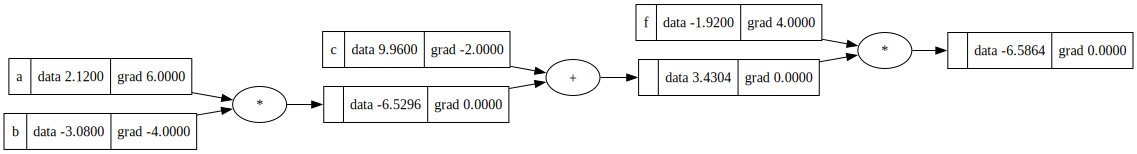

In [127]:
draw_dot(L)

## In the next mini-lesson, we will do another, more complex example of backpropogating. We will backpropogate through a neuron...